# Proyecto Final: Mushroom

In [2]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image

from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

alt.themes.enable('opaque')  # Para quienes utilizan temas oscuros en Jupyter Lab/Notebook
%matplotlib inline

## 1. Definicion del problema:

[MUSHROOM](https://archive.ics.uci.edu/ml/datasets/Mushroom)

Hay un sin fin de especies de hongos con diferentes propiedades y nos gustaria poder identificar cuales de estas aportan positivamente o negativamente. Identifcar las especies venenosas y analizar su anatomia. ¿Será posible saber a priori si un hongo es venenoso o no, con solo saber sus rasgos fisicos? De ser así, ¿podemos señalar que caracteristicas del hongo provocan que este sea venenoso?. Si se pudiera encontrar algun patron que nos ayude a identificar si una especies es venenosa o comestible, podria ser de utilidad para el desarrollo de nuevas medicinas.

Trabajaremos con una data de hongos en las familias [lepiota](https://en.wikipedia.org/wiki/Lepiota) y [agaricus](https://en.wikipedia.org/wiki/Agaricus), que incluye descripción, como veremos, de 22 variables que hablan de su estructura física. 

[abalone](../images/Lepiota_clypeolaria.png)

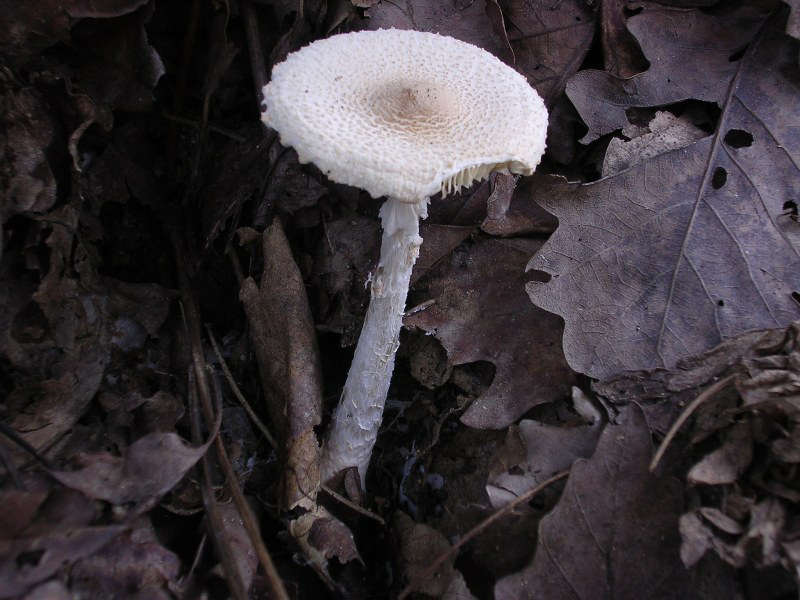

In [3]:
lepiota = Image.open(Path().resolve().parent / "images" / 'Lepiota_clypeolaria.jpg' )
lepiota

In [4]:
datapath = Path().resolve().parent / "data"

mushroom = pd.read_csv(
    datapath / "agaricus-lepiota.data",
    header=None,
    names=["class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment", "gill-spacing", 
           "gill-size", "gill-color", "stalk-shape", "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
           "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
           "spore-print-color",  "population" , "habitat"]
)

mushroom.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## 1.1. Información del data:

Antes de partir con la estadistica descriptiva nos gustaria explicar brevemente como esta compuesto la data.

In [5]:
%pycat ../data/agaricus-lepiota.names

1. Title: Mushroom Database

2. Sources: 
    (a) Mushroom records drawn from The Audubon Society Field Guide to North
        American Mushrooms (1981). G. H. Lincoff (Pres.), New York: Alfred
        A. Knopf
    (b) Donor: Jeff Schlimmer (Jeffrey.Schlimmer@a.gp.cs.cmu.edu)
    (c) Date: 27 April 1987

3. Past Usage:
    1. Schlimmer,J.S. (1987). Concept Acquisition Through Representational
       Adjustment (Technical Report 87-19).  Doctoral disseration, Department
       of Information and Computer Science, University of California, Irvine.
       --- STAGGER: asymptoted to 95% classification accuracy after reviewing
           1000 instances.
    2. Iba,W., Wogulis,J., & Langley,P. (1988).  Trading off Simplicity
       and Coverage in Incremental Concept Learning. In Proceedings of 
       the 5th International Conference on Machine Learning, 73-79.
       Ann Arbor, Michigan: Morgan Kaufmann.  
       -- approximately the same results with their HILLARY algorithm    
    3. In 

## 2. Estadística descriptiva:

In [6]:
mushroom.describe().T

,count,unique,top,freq
class,8124,2,e,4208
cap-shape,8124,6,x,3656
cap-surface,8124,4,y,3244
cap-color,8124,10,n,2284
bruises,8124,2,f,4748
odor,8124,9,n,3528
gill-attachment,8124,2,f,7914
gill-spacing,8124,2,c,6812
gill-size,8124,2,b,5612
gill-color,8124,12,b,1728


Como vemos en la tabla anterior todas nuestras variables corresponden a datos nominales, por lo tanto es probable que se haga un preprocesamiento, para así analizar de mejor manera nuestros datos. 

A continuación se presentara de una forma mas clara y amigable los respectivos clasificadores asociados a cada letra de las columnas.


| Feature       | Description     |
| :------------- | :----------: |
| cap-shape | bell=b, conical=c, convex=x,flat=f, knobbed=k, sunken=s|
| cap-surface|            fibrous=f,grooves=g,scaly=y,smooth=s|
| cap-color|                brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y|
| bruises?|                 bruises=t,no=f|
| odor|                     almond=a,anise=l,creosote=c,fishy=y,foul=f,musty=m,none=n,pungent=p,spicy=s|
| gill-attachment|          attached=a,descending=d,free=f,notched=n|
| gill-spacing|             close=c,crowded=w,distant=d|
| gill-size: |               broad=b,narrow=n|
| gill-color|               black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y|
| stalk-shape|              enlarging=e,tapering=t|
| stalk-root:|               bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?|
| stalk-surface-above-ring: |fibrous=f,scaly=y,silky=k,smooth=s|
|stalk-surface-below-ring: |fibrous=f,scaly=y,silky=k,smooth=s|
| stalk-color-above-ring: |  brown=n,buff=b,cinnamon=c,gray=g,orange=o, pink=p,red=e,white=w,yellow=y|
| stalk-color-below-ring:  | brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y|
| veil-type:    |            partial=p,universal=u|
| veil-color:   |            brown=n,orange=o,white=w,yellow=y|
| ring-number:   |           none=n,one=o,two=t|
| ring-type:     |           cobwebby=c,evanescent=e,flaring=f,large=l, none=n,pendant=p,sheathing=s,zone=z|
|spore-print-color: |       black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y|
| population:   |            abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y|
| habitat:     |             grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d|

## 3. Visualización descriptiva

Respecto a las visualizaciones, solo nos interesa saber la cantidad de elementos por cada categoria. Por lo mismo haremos histogramas para cada columna, diferenciando entre comestible o venenoso, que es información entregada en la primera columan del dataframe `mushroom`.

* Notar que en `stalk-root` tenemos muchos datos perdidos (2480), marcados con un "?". Es por esto, que reemplazaremos el caracter "?" por `NaN`.

In [7]:
mushroom.isna().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

In [8]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

A continuación se presentaran algunos gráficos de los cuales podemos extraer información.

C:\Users\benja\miniconda3\envs\mat281-v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


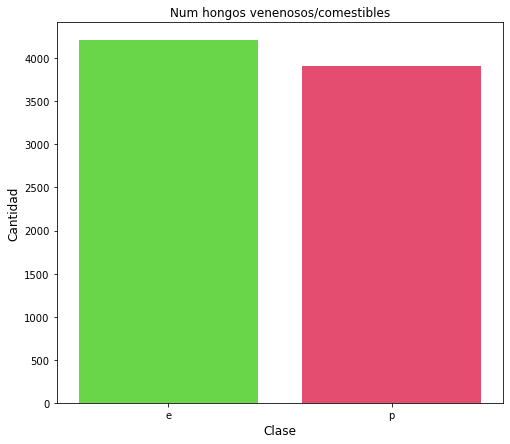

In [9]:
count = mushroom['class'].value_counts()
plt.figure(figsize=(8,7));
sns.barplot(count.index, count.values, alpha=0.8, palette="prism");
plt.ylabel('Cantidad', fontsize=12);
plt.xlabel('Clase', fontsize=12);
plt.title('Num hongos venenosos/comestibles');
plt.savefig("mushrooms1.png", format='png', dpi=500)
plt.show();

C:\Users\benja\miniconda3\envs\mat281-v2\lib\site-packages\pandas\plotting\_matplotlib\core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


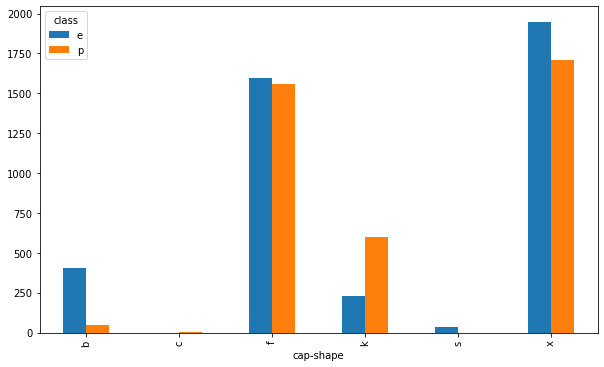

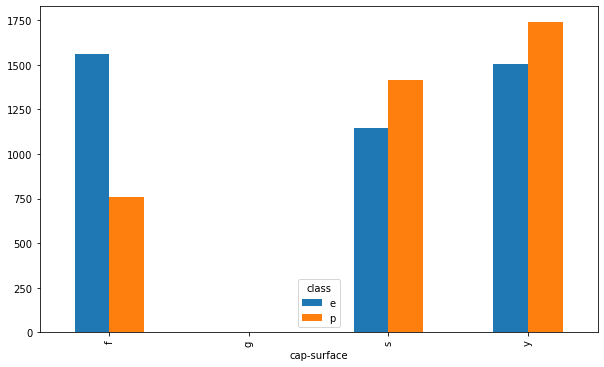

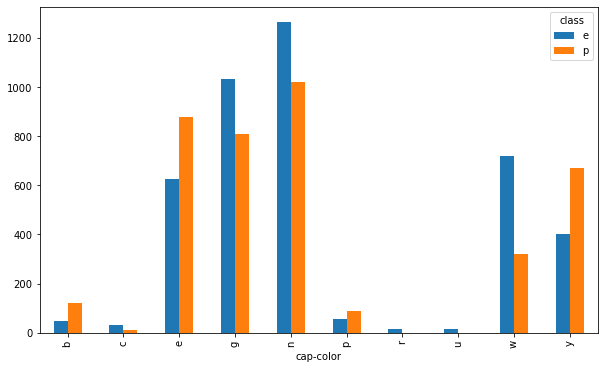

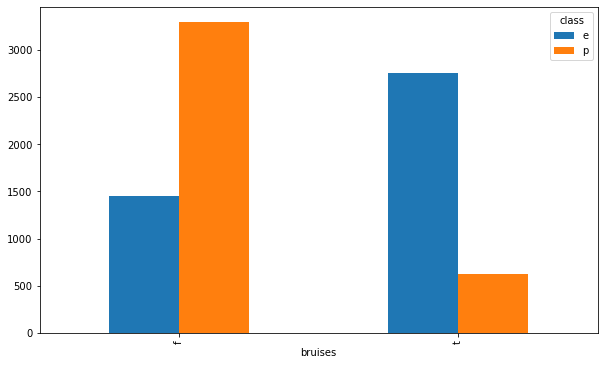

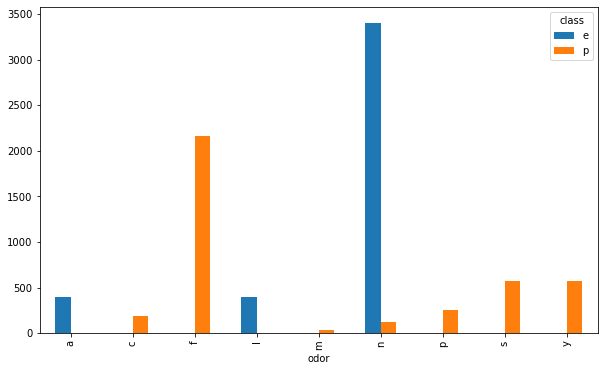

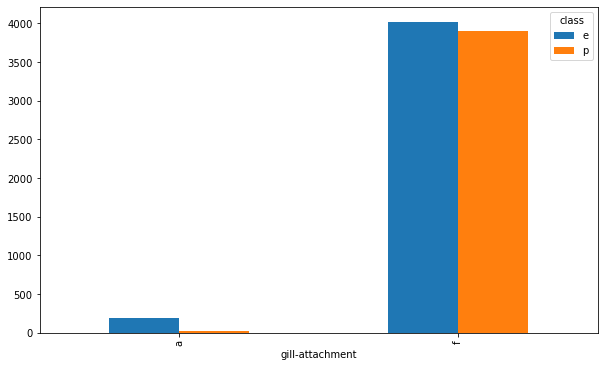

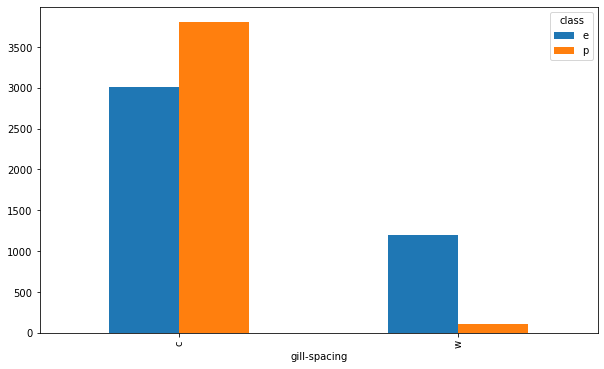

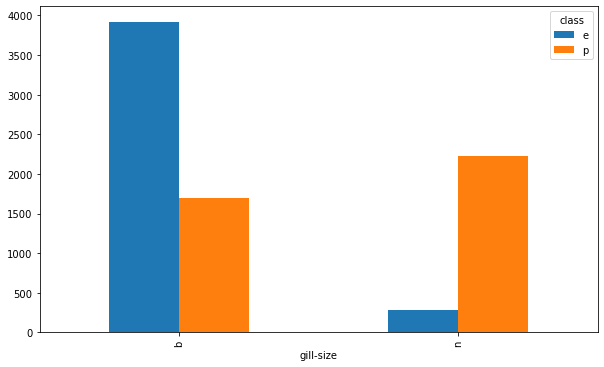

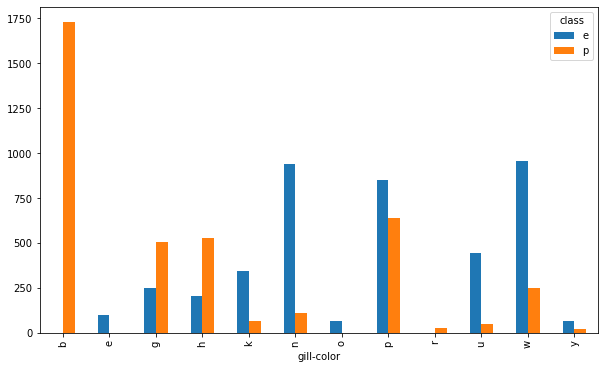

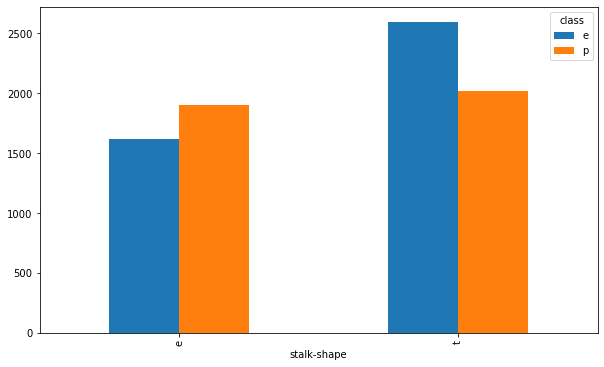

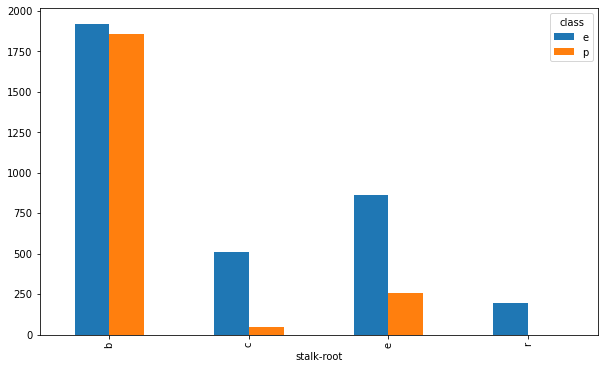

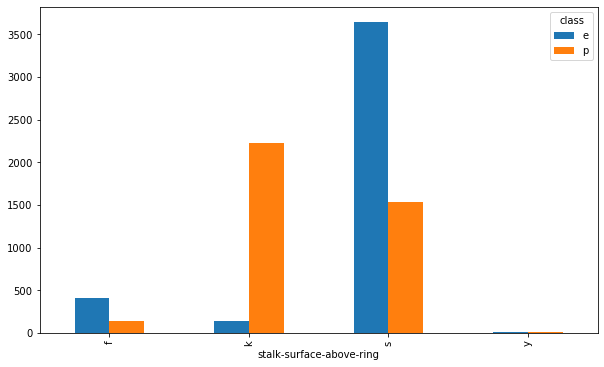

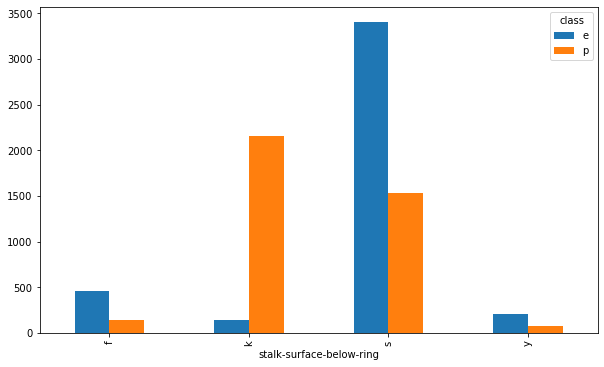

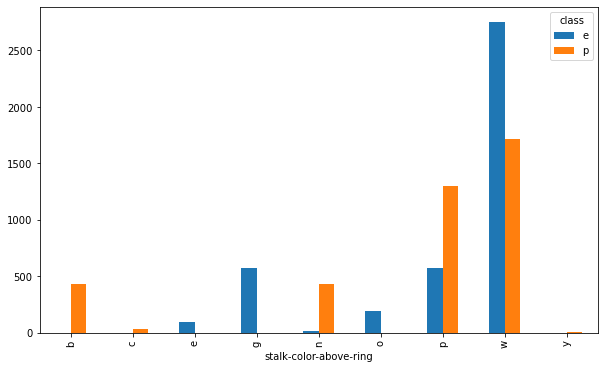

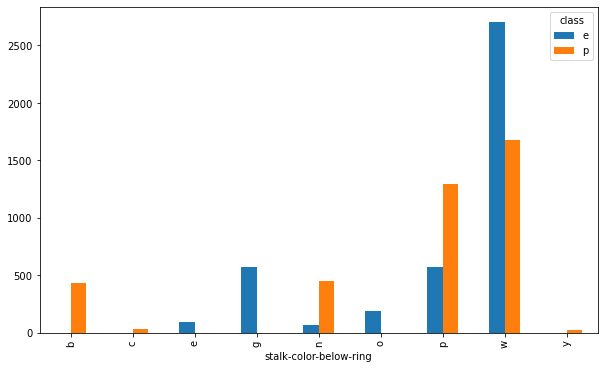

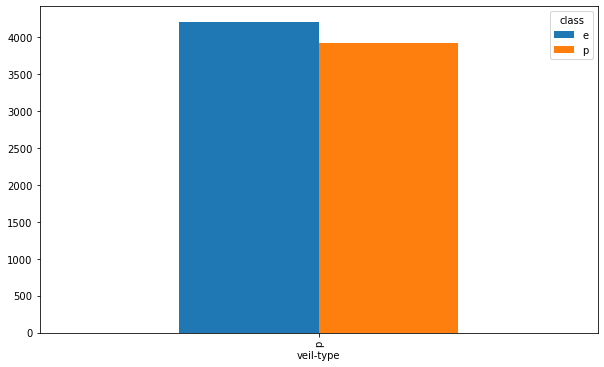

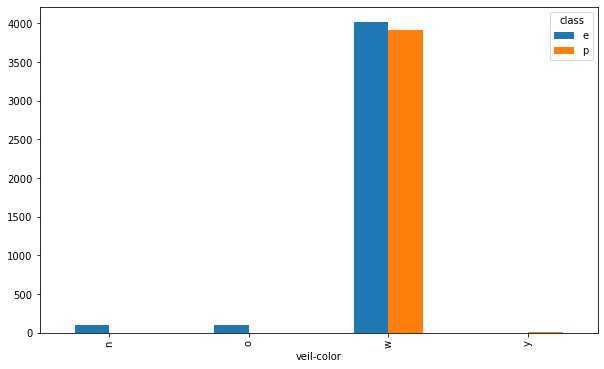

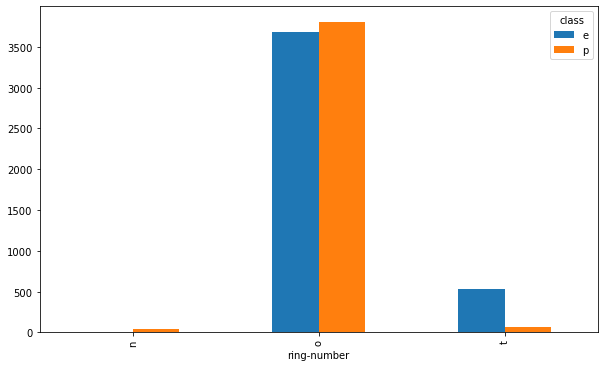

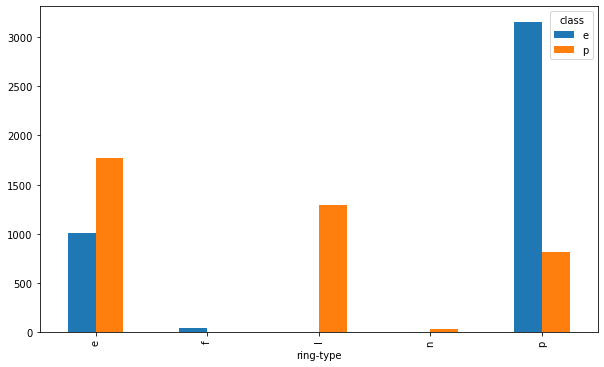

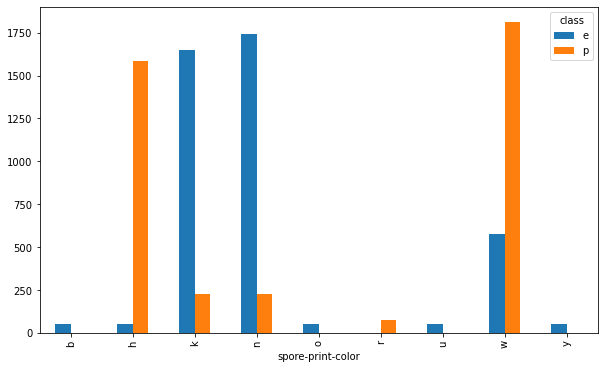

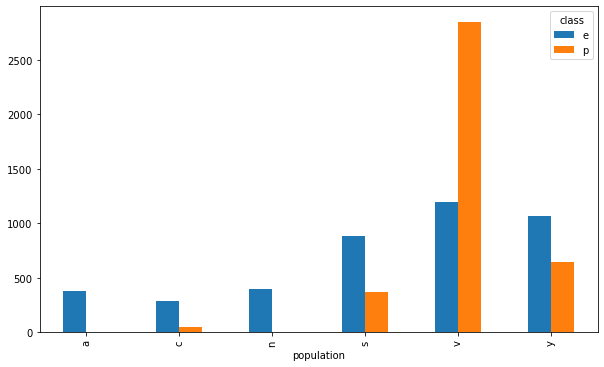

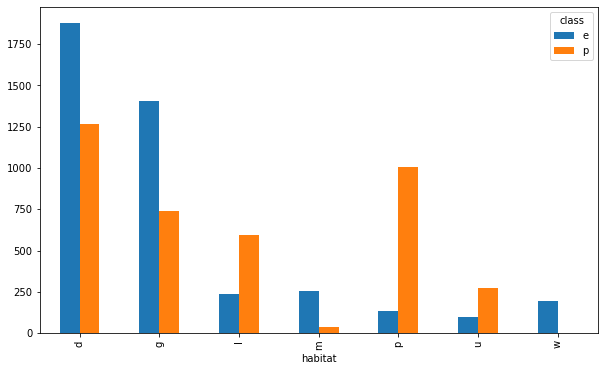

In [10]:
data = mushroom.copy()
data.replace({"?": np.nan}, inplace = True)
data["count_p_e"] = 1

for j in data.columns.drop(["class","count_p_e"]):
    df = data[["class",j,"count_p_e"]].groupby([j,"class"])["count_p_e"].apply(sum).unstack("class").replace(np.nan,0)
    df = df.reset_index()
    df.plot(x = j,kind='bar',figsize=(10,6));

Respecto al **preprocesamiento** podemos ver de forma exhaustiva con ayuda de `.describe` que las columnas solo tienen los elementos que deberían tener. A parte de esto no tenemos elementos nulos

In [11]:
data.isna().sum()

class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
count_p_e                      0
dtype: int64

De los histogramas anteriores podemos observar que la columna `veil-type` solo tiene un elemento (p = partial), el cual no nos entrega información alguna sobre nuestra problematica. Es por esta razon que decidimos eliminar esta columna.

In [12]:
mushroom['veil-type'].unique()

array(['p'], dtype=object)

In [13]:
mushroom.drop(["veil-type"],axis=1, inplace = True)

## 4. Preprocesamiento

A continuación convertiremos las variables categóricas en variables ficticias / indicadoras, para luego reducir las dimensiones usando el Análisis de componentes principales para reducir 23 variables categoricas (que se convertiran en 95 variables después de la conversión) a solo 2 variables (Componentes principales) y entrenando diferentes modelos de clasificación sobre estas dos componentes principales. En este trabajo no se dara preferencia a la preción ya que nuestro objetivo es visualizar los límites de decisión. 

In [14]:
X=mushroom.drop('class',axis=1) #Predictors
y=mushroom['class'] #Response
X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,x,s,n,t,p,f,c,n,k,e,...,s,s,w,w,w,o,p,k,s,u
1,x,s,y,t,a,f,c,b,k,e,...,s,s,w,w,w,o,p,n,n,g
2,b,s,w,t,l,f,c,b,n,e,...,s,s,w,w,w,o,p,n,n,m
3,x,y,w,t,p,f,c,n,n,e,...,s,s,w,w,w,o,p,k,s,u
4,x,s,g,f,n,f,w,b,k,t,...,s,s,w,w,w,o,e,n,a,g


In [15]:
from sklearn import preprocessing

In [16]:
Encoder_X = preprocessing.LabelEncoder() 
for col in X.columns:
    X[col] = Encoder_X.fit_transform(X[col])
    mushroom[col] = Encoder_X.fit_transform(mushroom[col])
Encoder_y = preprocessing.LabelEncoder()
y = Encoder_y.fit_transform(y)
df = mushroom

In [17]:
X.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,5,2,4,1,6,1,0,1,4,0,...,2,2,7,7,2,1,4,2,3,5
1,5,2,9,1,0,1,0,0,4,0,...,2,2,7,7,2,1,4,3,2,1
2,0,2,8,1,3,1,0,0,5,0,...,2,2,7,7,2,1,4,3,2,3
3,5,3,8,1,6,1,0,1,5,0,...,2,2,7,7,2,1,4,2,3,5
4,5,2,3,0,5,1,1,0,4,1,...,2,2,7,7,2,1,0,3,0,1


In [18]:
y

array([1, 0, 0, ..., 0, 1, 0])

Donde 
* 1 = Venenoso.
* 0 = Comestible.

### Obtener variables ficticias

In [19]:
X=pd.get_dummies(X,columns=X.columns,drop_first=True)
X.head()

,cap-shape_1,cap-shape_2,cap-shape_3,cap-shape_4,cap-shape_5,cap-surface_1,cap-surface_2,cap-surface_3,cap-color_1,cap-color_2,...,population_2,population_3,population_4,population_5,habitat_1,habitat_2,habitat_3,habitat_4,habitat_5,habitat_6
0,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0


### Dividir el conjunto de datos en el conjunto de entrenamiento y el conjunto de prueba

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

### Escalar las Feature

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Aplicar PCA con n_components = 2

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

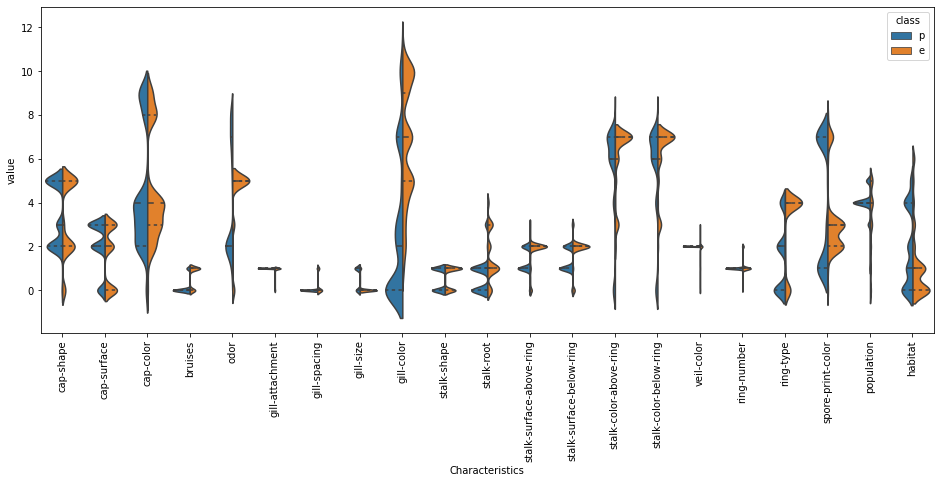

In [23]:
df_div = pd.melt(df, 'class', var_name='Characteristics')
fig, ax = plt.subplots(figsize=(16,6))
p = sns.violinplot(ax = ax, x='Characteristics', y='value', hue='class', split = True, data=df_div, inner = 'quartile')
df_no_class = df.drop(['class'],axis = 1)
p.set_xticklabels(rotation = 90, labels = list(df_no_class.columns));
#plt.savefig(“violinplot.png”, format=’png’, dpi=500, bbox_inches=’tight’)

Además también nos interesa verificar si existe alguna correlación entre las variables que se pueda ver facilmente

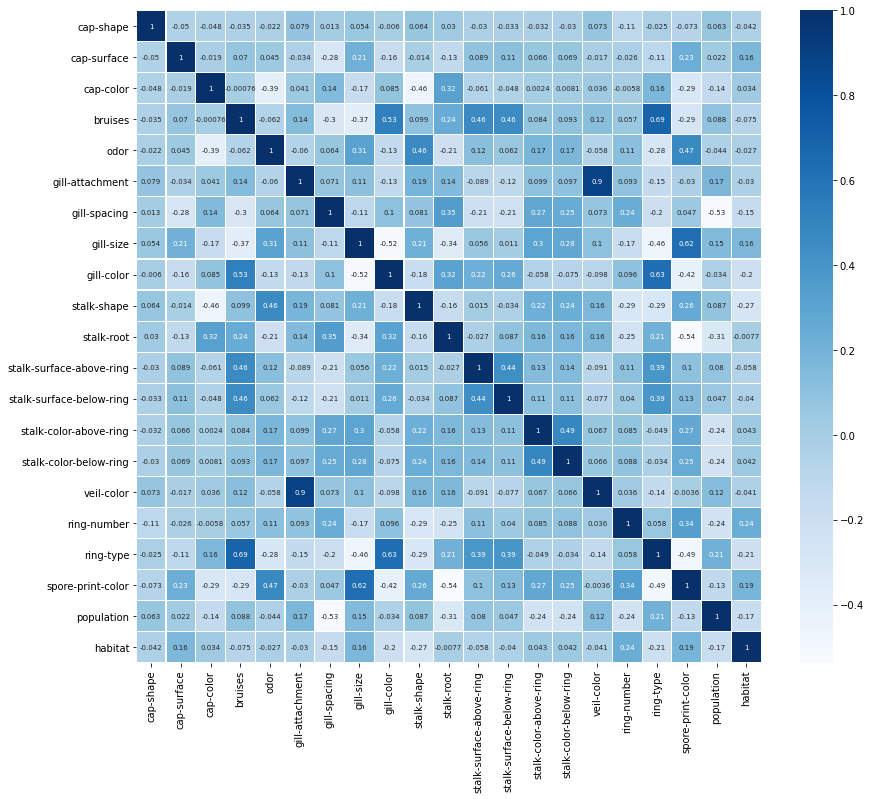

In [24]:
plt.figure(figsize=(14,12))
sns.heatmap(df.corr(),linewidths=.1,cmap="Blues", annot=True, annot_kws={"size": 7})
plt.yticks(rotation=0);
#plt.savefig("corr.png", format='png', dpi=400, bbox_inches='tight')

## 5. Modelos

A continuación se presentar cuatro modelos tentativos a usar. Los analizaremos y finalmente escogeremos uno para seguir nuestro desarrollo.

### 5.1. Regresión logística

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
#param_grid = {
#    "C": np.arange(0, 1, 0.01)
#}

#svc = SVC(C=1.0)
#search = GridSearchCV(
#    estimator=svc,
#    param_grid=param_grid
#)

#search.fit(X_train,y_train)
#search.best_params_

El mejor hiperparametro es C= 0.34

In [27]:
classifier1 = LogisticRegression(C = 0.34, max_iter=500)
classifier1.fit(X_train,y_train);

In [54]:
y_pred_lr = classifier1.predict(X_test)
print("{}%".format(round(classifier1.score(X_test, y_test)*100,2)))

90.16%


### 5.2. KNN

In [29]:
from sklearn.neighbors import KNeighborsClassifier

In [30]:
for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    score = knn.score(X_test, y_test)
    print(f"El score del modelo de kNN con k={i} es {score}")

El score del modelo de kNN con k=1 es 0.9015990159901599
El score del modelo de kNN con k=2 es 0.9163591635916359
El score del modelo de kNN con k=3 es 0.9249692496924969
El score del modelo de kNN con k=4 es 0.922509225092251
El score del modelo de kNN con k=5 es 0.9261992619926199
El score del modelo de kNN con k=6 es 0.9261992619926199
El score del modelo de kNN con k=7 es 0.923739237392374
El score del modelo de kNN con k=8 es 0.9212792127921279
El score del modelo de kNN con k=9 es 0.9261992619926199


El mejor hiperparametro es K=6.

In [55]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
print("{}%".format(round(knn.score(X_test, y_test)*100,2)))

92.62%


### 5.3. SVC

In [32]:
from sklearn.svm import SVC

In [33]:
#param_grid = {
#    "C": np.arange(0, 1, 0.01)
#}

#svc = SVC(C=1.0)
#search = GridSearchCV(
#    estimator=svc,
#    param_grid=param_grid
#)

#search.fit(X_train,y_train)
#search.best_params_

El mejor hiperparametro es C = 0.97

In [34]:
classifier3 = SVC(C = 0.97, kernel='rbf',random_state=42)
classifier3.fit(X_train,y_train);

In [35]:
y_pred_svc=classifier3.predict(X_test)
y_pred_svc=(y_pred_svc>0.5)

In [56]:
print("{}%".format(round(classifier3.score(X_test, y_test)*100,2)))

90.41%


### 5.4. Gaussian Naive Bayes

In [37]:
from sklearn.naive_bayes import GaussianNB as NB

classifier4 = NB()
classifier4.fit(X_train,y_train);

In [38]:
y_pred_gnb=classifier4.predict(X_test)
y_pred_gnb=(y_pred_gnb>0.5)

In [57]:
print("{}%".format(round(classifier4.score(X_test, y_test)*100,2)))

89.54%


## 6. Métricas y análisis de resultados

### Regreción logística

In [64]:
from sklearn.metrics import plot_precision_recall_curve, precision_recall_curve

In [40]:
y_pred_lr = classifier1.predict(X_test)
print("Regrecion logistica report: \n\n", classification_report(y_test, y_pred_lr))

Regrecion logistica report: 

               precision    recall  f1-score   support

           0       0.87      0.96      0.91       433
           1       0.95      0.83      0.89       380

    accuracy                           0.90       813
   macro avg       0.91      0.90      0.90       813
weighted avg       0.91      0.90      0.90       813



In [58]:
print("{}%".format(round(classifier1.score(X_test, y_test)*100,2)))

90.16%


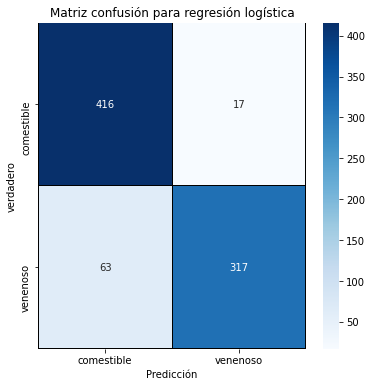

In [42]:
cm = confusion_matrix(y_test, y_pred_lr)

x_axis_labels = ["comestible", "venenoso"]
y_axis_labels = ["comestible", "venenoso"]

f, ax = plt.subplots(figsize =(6,6))
sns.heatmap(cm, annot = True, linewidths=0.1, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("Predicción")
plt.ylabel("verdadero")
plt.title('Matriz confusión para regresión logística')
#plt.savefig("lrcm.png", format='png', dpi=900, bbox_inches='tight')
plt.show()

### KNN

In [43]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train);

y_pred_knn = knn.predict(X_test)
print("KNN Classifier report: \n\n", classification_report(y_test, y_pred_knn))

KNN Classifier report: 

               precision    recall  f1-score   support

           0       0.91      0.91      0.91       433
           1       0.90      0.89      0.89       380

    accuracy                           0.90       813
   macro avg       0.90      0.90      0.90       813
weighted avg       0.90      0.90      0.90       813



In [59]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
print("{}%".format(round(knn.score(X_test, y_test)*100,2)))

92.62%


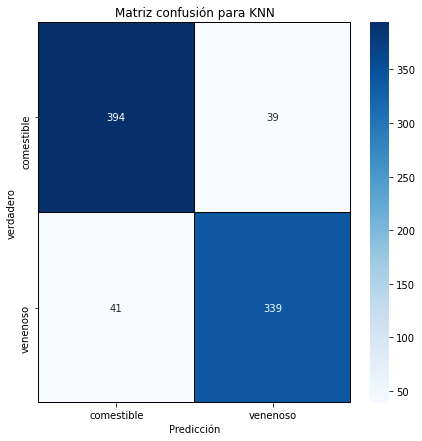

In [45]:
cm = confusion_matrix(y_test, y_pred_knn)

x_axis_labels = ["comestible", "venenoso"]
y_axis_labels = ["comestible", "venenoso"]


f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("Predicción")
plt.ylabel("verdadero")
plt.title('Matriz confusión para KNN')
#plt.savefig("knncm.png", format='png', dpi=900, bbox_inches='tight')
plt.show()

### SVC

In [46]:
print("SVC Classifier report: \n\n", classification_report(y_test, y_pred_svc))

SVC Classifier report: 

               precision    recall  f1-score   support

           0       0.86      0.97      0.92       433
           1       0.96      0.83      0.89       380

    accuracy                           0.90       813
   macro avg       0.91      0.90      0.90       813
weighted avg       0.91      0.90      0.90       813



In [60]:
print("{}%".format(round(classifier3.score(X_test, y_test)*100,2)))

90.41%


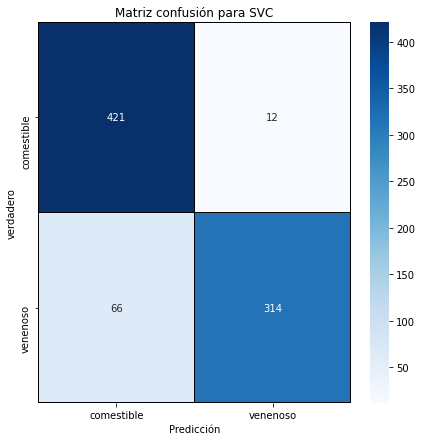

In [48]:
cm = confusion_matrix(y_test, y_pred_svc)

x_axis_labels = ["comestible", "venenoso"]
y_axis_labels = ["comestible", "venenoso"]


f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("Predicción")
plt.ylabel("verdadero")
plt.title('Matriz confusión para SVC')
#plt.savefig("knncm.png", format='png', dpi=900, bbox_inches='tight')
plt.show()

### Gaussian Naive Bayes

In [49]:
print("Naiye Bayes Classifier report: \n\n", classification_report(y_test, y_pred_gnb))

Naiye Bayes Classifier report: 

               precision    recall  f1-score   support

           0       0.86      0.96      0.91       433
           1       0.95      0.82      0.88       380

    accuracy                           0.90       813
   macro avg       0.90      0.89      0.89       813
weighted avg       0.90      0.90      0.89       813



In [61]:
print("{}%".format(round(classifier4.score(X_test, y_test)*100,2)))

89.54%


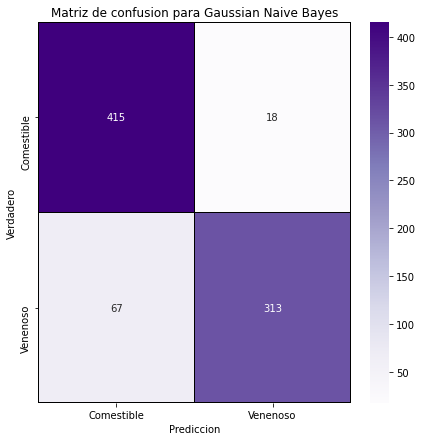

In [51]:
cm = confusion_matrix(y_test, y_pred_gnb)
x_axis_labels = ["Comestible", "Venenoso"]
y_axis_labels = ["Comestible", "Venenoso"]
f, ax = plt.subplots(figsize =(7,7))
sns.heatmap(cm, annot = True, linewidths=0.2, linecolor="black", fmt = ".0f", ax=ax, cmap="Purples", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel("Prediccion")
plt.ylabel("Verdadero")
plt.title('Matriz de confusion para Gaussian Naive Bayes')
#plt.savefig("nbcm.png", format='png', dpi=500, bbox_inches='tight')
plt.show()

### Resumiendo los datos obtenidos por los modelos:

| Modelo       | Mejor hiperparametro | Accuracy (Test)
| :------------- | :----------: | :----------: |
| Regresión Logistica | C = 0.34 | 90.16%
| KNN| K = 6| 92.62%|
| SVC| C = 0.97| 90.41%|
| Gaussian Naive Bayes| - | 89.54%|

Como el error de predicción en el modelo KNN es mejor nos quedamos con él como el modelo ganador.

## 7. Visualizaciones del modelo

## 8. Conclusiones

* No es muy confiable a pesar de tener cerca de un 90% aprox de confiabilidad.
* No fue muy relevante el hecho de que trabajaramos con puras variables nominales.
* 